In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Dataframes complementarios (Traducción de IDs)                                         # 1ra Columna   -> Resto de columnas
df_id_banco = pd.read_csv("Data/ExtraccionDomiVersionFinal/CatBanco.csv")                # ID Banco      -> Nombre del banco
df_id_emisora = pd.read_csv("Data/ExtraccionDomiVersionFinal/CatEmisora.csv")            # ID Emisora    -> Nombre Emisora, ID Banco, Emisora??, Tipo envío
df_id_respuesta = pd.read_csv("Data/ExtraccionDomiVersionFinal/CatRespuestaBancos.csv")  # ID Respuesta  -> Descripción
df_id_listaemisor = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroEmisora.csv") # ID ListaCobro -> ID Emisora

# Dataframes detallados por año
df_2022 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2022.csv")
df_2023 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2023.csv")
df_2024 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2024.csv")
df_2025 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2025.csv")

C:\Users\Jose Armando\AppData\Local\Temp\ipykernel_3200\877011849.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2023.csv")


In [3]:
cobros_detallados = pd.concat([df_2022, df_2023, df_2024, df_2025], ignore_index=True)
cobros_detallados.rename(columns={
    'idRespuestaBanco': 'IdRespuestaBanco',
    'idBanco': 'IdBanco'
}, inplace=True)

cobros_detallados.head()

,idListaCobro,idCredito,consecutivoCobro,IdBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,IdRespuestaBanco
0,100613,83021,27169966,2,572.24,572.24,0.0,NaN,04
1,100613,87227,27169937,2,517.74,517.74,0.0,NaN,04
2,100613,103785,27169946,2,681.23,681.23,0.0,NaN,04
3,100613,110463,27169969,2,572.24,572.24,0.0,NaN,04
4,100613,113755,27169948,2,340.62,340.62,0.0,NaN,04


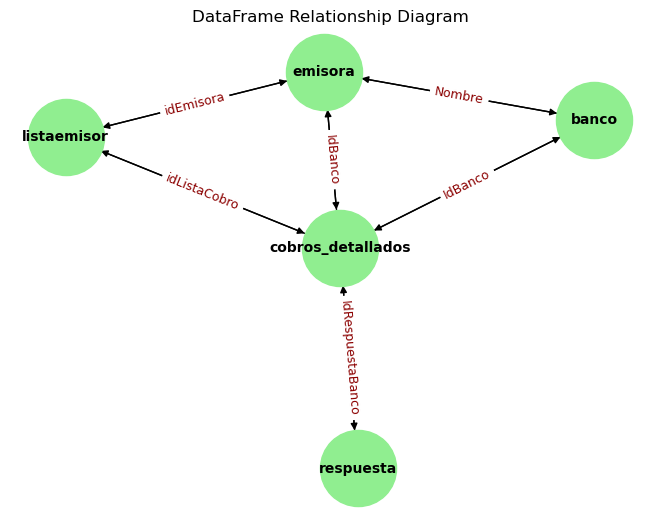

In [4]:
import networkx as nx

dataframes = {
    "banco": df_id_banco,
    "emisora": df_id_emisora,
    "respuesta": df_id_respuesta,
    "listaemisor": df_id_listaemisor,
    "cobros_detallados": cobros_detallados
}

G = nx.DiGraph()

# Add nodes
for name in dataframes:
    G.add_node(name)

# Compare columns to detect relationships (shared column names)
for table_a, df_a in dataframes.items():
    for table_b, df_b in dataframes.items():
        if table_a != table_b:
            shared_keys = set(df_a.columns).intersection(df_b.columns)
            for key in shared_keys:
                # A -> B if B references a key from A
                G.add_edge(table_b, table_a, label=key)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightgreen", node_size=3000, font_size=10, font_weight="bold", arrows=True)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="darkred", font_size=9)

plt.title("DataFrame Relationship Diagram")
plt.show()
